In this notebook we are going to walk through a single patient example. There are probably some patient-specific stuff in here that might change with other patients. Should be able to demonstrate the usage of different functions from the toolbox.

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress
import pandas as pd
from scipy.stats import kurtosis
import h5py
from mne.preprocessing.bads import _find_outliers

In [2]:
# Import utility functions from our toolbox

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils

# Load the data and clean up MNE structure

In [4]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results 

save_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/MS007'  # save intermediate results in the 'work' directory
    
# I have saved most of my raw data in the 'projects directory'
behav_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/behav/Day1'
neural_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/neural/Day1'
anat_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/anat'
edf_files = glob(f'{neural_dir}/*.edf')




Try loading in the data into memory

In [5]:
MS007_data = mne.io.read_raw_edf(edf_files[0], preload=True)
# If you try to preload, it will kill the kernel (at mem=4000). Probably need to request more memory in Minerva (mem=8000 seems to work)


Extracting EDF parameters from /sc/arion/projects/guLab/Salman/EMU/MS007/neural/Day1/MS007_MemBandit.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1867007  =      0.000 ...  1823.249 secs...


In [10]:
# # If not preloading: 
# raw_data = MS007_data.get_data()

In [10]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

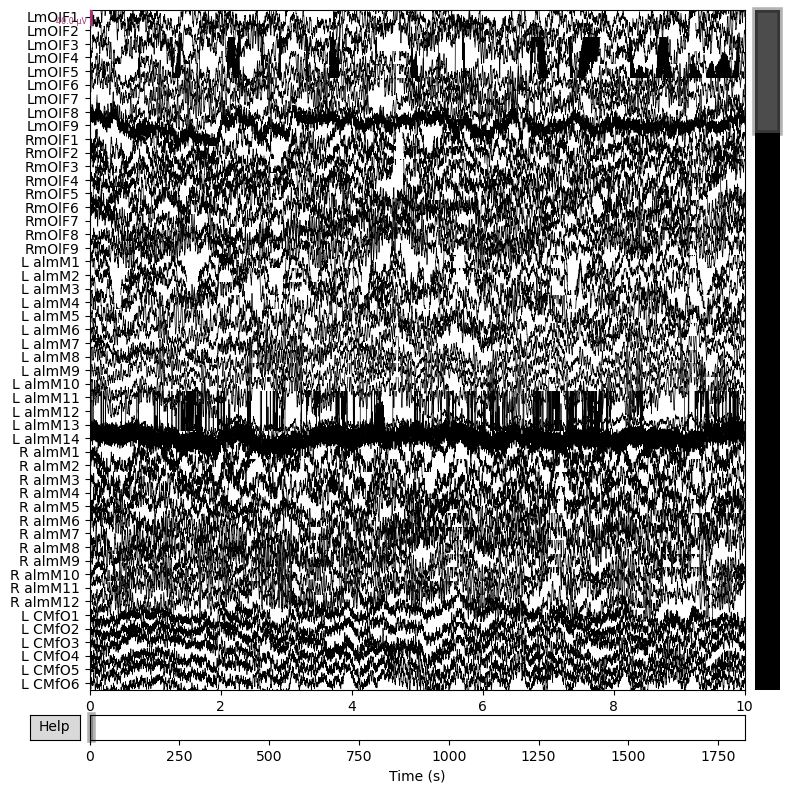

In [11]:
# this command sets the backend so that the plots are interactive
# get_ipython().run_line_magic('matplotlib', 'qt')

# plot all channels so that irrelevant/noisy channels can be saved as bad
MS007_data.plot(n_channels=50)

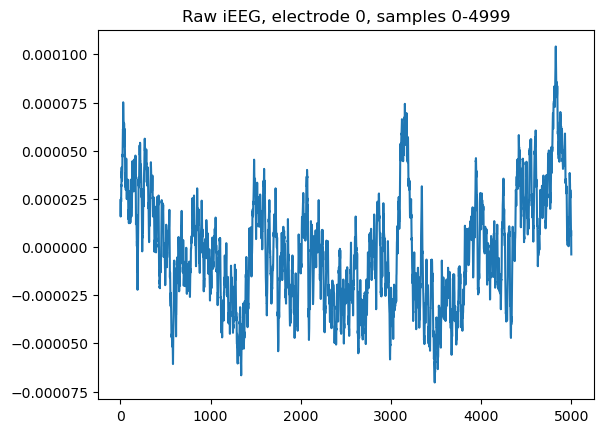

In [7]:
# Sanity check
plt.plot(MS007_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

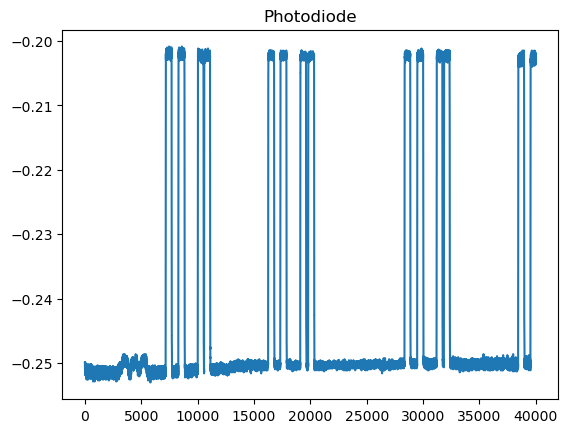

In [8]:
# Sanity check the photodiode
trig_ix = MS007_data.ch_names.index('DC1')
plt.plot(MS007_data._data[trig_ix, 10000:50000])
plt.title("Photodiode")
plt.show()

In [11]:
# Load the electrode localization data and add it in

csv_files = glob(f'{anat_dir}/*labels.csv')
elec_locs = pd.read_csv(csv_files[0])

# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]


The electrode names read out of the edf file do not always match those 
in the pdf (used for localization). This could be error on the side of the tech who input the labels, 
or on the side of MNE reading the labels in. Usually there's a mixup between lowercase 'l' and capital 'I'.

Sometimes, there's electrodes on the pdf that are NOT in the MNE data structure... let's identify those as well. 


In [12]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(MS007_data.ch_names, elec_locs.label)



Could not find a match for rhplt9.


So we retun a new list of channel names for the mne data structure as well as a list of channels in the localization csv which are not found in the mne structure. Make sure that unmatched_seeg does not factor into any referencing schemes later - it's not in the MNE data

In [17]:
# Rename the mne data according to the localization data
new_name_dict = {x:y for (x,y) in zip(MS007_data.ch_names, new_mne_names)}
MS007_data.rename_channels(new_name_dict)

<RawEDF | MS007_MemBandit.edf, 276 x 1867008 (1823.2 s), ~3.84 GB, data loaded>

In [18]:
MS007_data.ch_names

['lmolf1',
 'lmolf2',
 'lmolf3',
 'lmolf4',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lmolf8',
 'lmolf9',
 'rmolf1',
 'rmolf2',
 'rmolf3',
 'rmolf4',
 'rmolf5',
 'rmolf6',
 'rmolf7',
 'rmolf8',
 'rmolf9',
 'laimm1',
 'laimm2',
 'laimm3',
 'laimm4',
 'laimm5',
 'laimm6',
 'laimm7',
 'laimm8',
 'laimm9',
 'laimm10',
 'laimm11',
 'laimm12',
 'laimm13',
 'laimm14',
 'raimm1',
 'raimm2',
 'raimm3',
 'raimm4',
 'raimm5',
 'raimm6',
 'raimm7',
 'raimm8',
 'raimm9',
 'raimm10',
 'raimm11',
 'raimm12',
 'lcmfo1',
 'lcmfo2',
 'lcmfo3',
 'lcmfo4',
 'lcmfo5',
 'lcmfo6',
 'lcmfo7',
 'lcmfo8',
 'lcmfo9',
 'lcmfo10',
 'lcmfo11',
 'lcmfo12',
 'lcmfo13',
 'lcmfo14',
 'c59',
 'c60',
 'c61',
 'c62',
 'c63',
 'c64',
 'rcmfo1',
 'rcmfo2',
 'rcmfo3',
 'rcmfo4',
 'rcmfo5',
 'rcmfo6',
 'rcmfo7',
 'rcmfo8',
 'rcmfo9',
 'rcmfo10',
 'rcmfo11',
 'rcmfo12',
 'rcmfo13',
 'rcmfo14',
 'lacas1',
 'lacas2',
 'lacas3',
 'lacas4',
 'lacas5',
 'lacas6',
 'lacas7',
 'lacas8',
 'lacas9',
 'lacas10',
 'lacas11',
 'lacas12',
 'racas

# Synchronize to behavioral data

In [19]:
# Find the timestamps of ONSET and OFFSET of all sync pulses in "DC1"

trig_ix = MS007_data.ch_names.index('dc1')
sig = np.squeeze(sync_utils.moving_average(MS007_data._data[trig_ix,:], n=11))
timestamp = np.squeeze(np.arange(len(sig))/MS007_data.info['sfreq'])
# normalize
sig =  zscore(sig)
trig_ix = np.where((sig[:-1]<=0)*(sig[1:]>0))[0] # rising edge of trigger
neural_ts = timestamp[trig_ix]
neural_ts = np.array(neural_ts)
print(f'There are {len(neural_ts)} neural syncs detected')

There are 485 neural syncs detected


So, to go from logtime to neural time: 

behav_time_in_neural_time = [(behav_ts*slopes[subj][0] + offsets[subj][0]) for behav_ts in all_behav_ts]


In [20]:
log_path = glob(f'{behav_dir}/*.log')[0]

In [21]:
csv_path = glob(f'{behav_dir}/*MB_MEM*.csv')[0]

The next step pulls relevant timestamps from the behavioral logfile. THIS STEP DIFFERS DEPENDING ON YOUR TASK. 

Maybe one day this step will be unified across all tasks (i.e. either we have a programmer make our tasks, or we unify best practices for task design). 

In [22]:
# Now get the relevant timestamps from behavioral logfiles. This will differ depending

MB1_ts = {'trial_start': [], 
'deck_start': [], 
'feedback_start': [],
'ITI_start': [],
'ITI_stop': []}

MEM2_ts = {'trial_start': [], 
'face_start': [], 
'slider_start': [],
'slider_stop': [],
'ITI_start': [],
'ITI_stop': []}

beh_ts = []

MB1_FLAG = True 
MEM2_FLAG = False 

with open(log_path, 'r') as fobj:
    for ix, line in enumerate(fobj.readlines()):
        line = line.replace('\r', '')
        tokens = line[:-1].split('\t')

        if tokens[1] == 'EXP ':
            # Determine which task we are looking at 
            if tokens[2][0:3] == 'MB1':
                MB1_FLAG = True
                MEM2_FLAG = False 
            elif tokens[2][0:3] == 'MEM':
                MEM2_FLAG = True
                MB1_FLAG = False

            # Grab photodiode timestamp
            if tokens[2][0:4] =='sync':
                if 'autoDraw = True' in tokens[2]:
                    beh_ts.append(float(tokens[0]))

            # Get MB1 deck 
            if 'MB1_left_draw' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MB1_ts['deck_start'].append(float(tokens[0]))
            
            # Get MB1 feedback
            if 'MB1_face' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MB1_ts['feedback_start'].append(float(tokens[0]))

            # Get MB1 ITI cross 
            if 'MB1_ITI_cross' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MB1_ts['ITI_start'].append(float(tokens[0]))
                elif 'autoDraw = False' in tokens[2]:
                    MB1_ts['ITI_stop'].append(float(tokens[0]))

            if 'New trial (rep=0' in tokens[2]:
                if MB1_FLAG: 
                    # remember to discard the first one later - it's pre-session 
                    MB1_ts['trial_start'].append(float(tokens[0]))
                elif MEM2_FLAG:
                    MEM2_ts['trial_start'].append(float(tokens[0]))
            
            # Get MEM2 ITI
            if 'MEM2_jitter' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MEM2_ts['ITI_start'].append(float(tokens[0]))          
                elif 'autoDraw = False' in tokens[2]:
                    MEM2_ts['ITI_stop'].append(float(tokens[0]))  

            # Get MEM2 Face
            if 'MEM2_images' in tokens[2]:
                if 'autoDraw = True' in tokens[2]:
                    MEM2_ts['face_start'].append(float(tokens[0]))     

            # Get MEM2 slider start
            if tokens[2][:16] == 'MEM2_conf_slider':
                if 'autoDraw = True' in tokens[2]:
                    MEM2_ts['slider_start'].append(float(tokens[0]))    
             
             # Get MEM2 slider stop
            if tokens[2][:16] == 'MEM2_conf_slider':
                if 'autoDraw = False' in tokens[2]:
                    MEM2_ts['slider_stop'].append(float(tokens[0]))                                               
                    
beh_ts = np.array(beh_ts)
print(f'There are {len(beh_ts)} behav syncs detected')

# Note: fixation crosses need fixing on stop time duplicates
MB1_ts['ITI_stop'] = np.unique(MB1_ts['ITI_stop']).tolist()
MEM2_ts['ITI_stop'] = np.unique(MEM2_ts['ITI_stop']).tolist()


# Get the choice times: 
csv_data = pd.read_csv(csv_path)
MB1_ts['choice'] = (csv_data['MB1_draw_key.started'].dropna() + csv_data['MB1_draw_key.rt'].dropna()).tolist()
MEM2_ts['choice'] = (csv_data['MEM2_recall_key.started'].dropna() + csv_data['MEM2_recall_key.rt'].dropna()).tolist()

# Do some corrections: 
# Get rid of first trial start (pre-session)
MB1_ts['trial_start'].pop(0) 

There are 486 behav syncs detected


381.5762

Sanity check - the sync pulses are similar in number. That's nice, but not guaranteed. 

In [23]:
# Do regression to find neural timestamps for each event type
if len(beh_ts)!=len(neural_ts):
    good_beh_ms, neural_offset = sync_utils.pulsealign(beh_ts, neural_ts, window=50, thresh=0.95)
    slope, offset, rval = sync_utils.sync_matched_pulses(good_beh_ms, neural_offset)
else:
    slope, offset, rval = sync_utils.sync_matched_pulses(beh_ts, neural_ts)

if rval < 0.99:
    print('sync failed')
else: 
    print('sync succeeded')

50 blocks
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . found matches for 36 of 50 blocks
sync succeeded


In [18]:
# sync_data = pd.DataFrame(columns=['slope', 'offset'])
# sync_data.slope = [slope]
# sync_data.offset = [offset]
# sync_data.to_csv(f'{save_dir}/sync_data.csv', index=False)


In [19]:
# pd.DataFrame(MB1_ts).to_csv(f'{save_dir}/MB1_ts.csv', index=False)
# pd.DataFrame(MEM2_ts).to_csv(f'{save_dir}/MEM2_ts.csv', index=False)

# Now process the behavioral data

Here, one should load in their functions for behavioral stuff. I'll just write the functions relevant to me here for demonstration purposes. 

In [24]:
# Utility functions for image memorability ratings. 
import pandas as pd 
import numpy as np 
import os 
from scipy.stats import norm, zscore, linregress

# Note: Much of the following is ported from: https://github.com/cvzoya/memorability-distinctiveness

def dprime(pHit, pFA, PresentT, AbsentT, criteria=False):
    """
    Note: from: http://nikos-konstantinou.blogspot.com/2010/02/dprime-function-in-matlab.html
    
    
    Parameters
    ----------
    pHit : float
        The proportion of "Hits": P(Yes|Signal)
    pFA : float
        The proportion of "False Alarms": P(Yes|Noise)
    PresentT : int
        The number of Signal Present Trials e.g. length(find(signal==1))
    AbsentT : int
        The number of Signal Absent Trials e.g. length(find(signal==0))

        
    Returns
    -------
    dPrime: float
        signal detection theory sensitivity measure 
    
    beta: float
        optional criterion value
        
    C: float
        optional criterion value
        
    """

    if pHit == 1: 
        # if 100% Hits
        pHit = 1 - (1/(2*PresentT))
    
    if pFA == 0: 
        # if 0% FA 
        pFA = 1/(2*AbsentT)
        
    # Convert to Z-scores
    
    zHit = norm.ppf(pHit) 
    zFA = norm.ppf(pFA) 
    
    # calculate d-prime 
    
    dPrime = zHit - zFA 
    
    if criteria:
        beta = np.exp((zFA**2 - zHit**2)/2)
        C = -0.5 * (zHit + zFA)    
        return dPrime, beta, C
    else:
        return dPrime
    
# def calcMI(pmf):
#     """
    
#     Parameters
#     ----------
    
    
#     Returns
#     -------
    
#     """
        
#     pmf_1 = np.sum(pmf,axis=1) #  marginal over first variable
#     pmf_2 = np.sum(pmf,axis=0) # marginal over second variable
    
#     MI = 0
#     for i in range(np.shape(pmf)[0]):
#         for j in range(np.shape(pmf)[1]):
#             MI += pmf[i, j] * np.log(pmf[i, j] / (pmf_1[i]*pmf_2[j]))
            
#     return MI

def compute_memorability_scores(hits, false_alarms, misses, correct_rejections):
    """
    Parameters
    ----------
    hits : array-like
        TODO
    false_alarms : array-like
        TODO
    misses : array_like 
        TODO
    correct_rejections : array_like 
        TODO
        
    Returns
    -------
    memory_ratings : pandas DataFrame 
        DataFrame with the following ratings added: HR (hit rate), FAR (false alarm rate), ACC (accuracy), DPRIME (d-prime), MI (mutual information)
    """
    
    

    len_args = [len(hits), len(false_alarms), len(misses), len(correct_rejections)]
    if not all(len_args[0] == _arg for _arg in len_args[1:]):
            raise ValueError("All parameters must be the same length.")
    
    memory_ratings = pd.DataFrame(columns = ['HR', 'FAR', 'ACC', 'DPRIME'])
    # , 'MI'
    
    reg = 0.1 # regularization for MI calculation

    nstimuli = len(hits) 

    hm = hits+misses
    fc = false_alarms+correct_rejections

    hrs = hits/hm
    fars = false_alarms/fc
    accs = (hits+correct_rejections)/(hm+fc)

    dp = []
#     mis = []
    for i in range(nstimuli):
        dp.append(dprime(hrs[i], fars[i], hm[i], fc[i]))
#         pmf = np.array([[correct_rejections, misses], 
#                [false_alarms, hits]]) + reg
#         pmf = pmf/np.sum(pmf)
#         mis.append(calcMI(pmf))
    

    memory_ratings['HR'] = hrs
    memory_ratings['FAR'] = fars
    memory_ratings['ACC'] = accs
    memory_ratings['DPRIME'] = dp
#     memory_ratings['MI'] = mis
    
    return memory_ratings

In [25]:
subj_count = 0

# Load the database with image DPRIME information
database_file = f'{behav_dir}/all_mem_data.xlsx' 
all_mem_df = pd.read_excel(database_file, engine='openpyxl')
all_mem_df = all_mem_df[['img_path', 'DPRIME']]

# Turn into right format for modeling: 
MB1_n = 60
MEM2_n = 120
li_mb1 = []
li_mem2 = [] 

act_rew_rate = {}
act_rew_rate['pids'] = []

r1_chance=30

for elem in ['actions', 'rewards']:
    act_rew_rate[elem] = np.zeros(MB1_n).astype(int) # len(task_files), 

# Load the merged task data 
csv_data['trials_2.thisN'] = csv_data['trials_2.thisRepN'].shift(-1)

##### First, process the Bandit task: 
mb_df = csv_data.dropna(subset=['trials_2.thisN'])
act_rew_rate['pids'].append(mb_df.participant.iloc[0])

# Change Gender so that female = 2
mb_df.Gender[mb_df.Gender==0] = 2

# add score, reward probability and expected value 
mb_df['choice'] = mb_df.apply(lambda x: x['MB1_draw_key.keys'], axis=1)
# Make the trials 1-60 
mb_df['trials_dm'] = mb_df['trials_2.thisN'].shift(+1)
# mb_df.trials_dm.fillna(60, inplace=True)
# # get rid of the extra rows in the .csv that populate between trials 
mb_df = mb_df.drop_duplicates(subset='trials_dm', keep='first')
mb_df['reward'] = mb_df.apply(lambda x: x['reward']/100, axis=1)
mb_df.reward[mb_df.reward==100] = 0
# 0 is male, 1 is female 
mb_df['choice'] = mb_df['choice']-1
mb_df.rename(columns={'MB1_draw_key.rt':'draw_rt'}, inplace=True)
mb_df.dropna(subset=['img_path'], inplace=True)

# # check chance: 
# if mb_df.reward.sum() < r1_chance:
#     # print(f'Subject {subj_count} performed worse than random')
#     bad_subs.append(subj_count)
#     continue

##### Fit RW model to DM data
mb_df['bic'] = np.nan
mb_df['alpha']  = np.nan
mb_df['beta']  = np.nan
mb_df['RPE']  = np.nan

# RW_model = RW() 
sub_act_rew_rate = {}
sub_act_rew_rate['pids'] = np.array([subj_count])  

for elem in ['actions', 'rewards']:
    sub_act_rew_rate[elem] = np.zeros([1, MB1_n]).astype(int)
c = mb_df.choice.dropna().values.astype(int)
r = mb_df.reward.dropna().values
sub_act_rew_rate['actions'][0, :] = c
sub_act_rew_rate['rewards'][0, :] = r
# RW_model.fit_all(sub_act_rew_rate) 

# mb_df.RPE= RW_model.fit_metrics['prederr'][0].tolist()
# mb_df.bic= RW_model.fit_metrics['bic'][0]
# mb_df.alpha= RW_model.fit_metrics['params']['alpha'][0]
# mb_df.beta= RW_model.fit_metrics['params']['beta'][0]

# Save dict for modeling decision-making performance: 
c = mb_df.choice.dropna().values.astype(int)
r = mb_df.reward.dropna().values
act_rew_rate['actions'] = c # [subj_count, :]
act_rew_rate['rewards']= r # [subj_count, :]

##### Second, process the MEM2 data: 
rm_df = csv_data.dropna(subset=['MEM2_trials.thisN'])

# add coding of memory choice: 
rm_df['hit'] = 0
rm_df['miss'] = 0
rm_df['corr_reject'] = 0
rm_df['false_alarm'] = 0

# add score, reward probability and expected value 
rm_df.rename(columns={'MEM2_recall_key.keys': 'response',
'MEM2_conf_slider.response': 'confidence'
 }, inplace=True) 

rm_df['trials_mem'] = rm_df['MEM2_trials.thisN'].shift(-1)
rm_df.trials_mem.fillna(120, inplace=True)

# Change Gender so that female = 2
rm_df.Gender[rm_df.Gender==0] = 2

rm_df = rm_df.merge(mb_df, on='img_path', how='left', indicator=True)
# Clean up the merge
rm_df.drop(columns=['participant_y'], inplace=True)
rm_df.rename(columns={'participant_x': 'participant'}, inplace=True)


# compute the hit-rates and false-alarm rates 
### TO do so, use the merge to find image_paths that were in "both" dfs ('old') 
# OLD = 2, which is correct in this case 
hit_bool = (rm_df._merge=='both') & (rm_df.response==2)
hits = hit_bool.sum()
# NEW = 1, which is false in this case 
miss_bool = (rm_df._merge=='both') & (rm_df.response==1)
misses = miss_bool.sum()

# or just the "left" df ('new')
false_alarm_bool = (rm_df._merge=='left_only') & (rm_df.response==2)
false_alarms = false_alarm_bool.sum()
corr_reject_bool = (rm_df._merge=='left_only') & (rm_df.response==1)
correct_rejections = corr_reject_bool.sum()

# categorize image by memory choice
rm_df.hit[hit_bool] = 1
rm_df.miss[miss_bool] = 1
rm_df.false_alarm[false_alarm_bool] = 1
rm_df.corr_reject[corr_reject_bool] = 1

# compute dprime for the subject
hm = hits+misses
fc = false_alarms+correct_rejections

hrs = hits/hm
fars = false_alarms/fc

# Adjust extreme hit-rates or false-alarms
if hrs == 0: 
    hrs = 0.5/hm
elif hrs ==1: 
    hrs = (hm-0.5)/hm
if fars == 0: 
    fars = 0.5/fc
elif fars ==1: 
    fars = (fc-0.5)/fc

#  only the extreme values by replacing rates of 0 with 0.5/𝑛 and rates of 1 with (𝑛−0.5)/𝑛 where 𝑛 is the number of signal or noise trials (Macmillan & Kaplan, 1985)

dp = dprime(hrs, fars, hm, fc)

# Add in subject-level memory characteristics ("rates")
rm_df['hit_rate'] = hrs
rm_df['false_alarm_rate'] = fars
rm_df['subj_dprime'] = np.nan
if dp != float("-inf"):
    rm_df['subj_dprime'] = dp    

# # Get rid of horrible mmemory performers 
# if rm_df.subj_dprime.mean()<=0:
#     bad_subs.append(subj_count)
#     continue

# # Get patient demographics
# rm_df['age'] = np.nan
# rm_df['subj_gender'] = np.nan
# rm_df['age'] = demographics_df[demographics_df.participant==rm_df.participant.iloc[0]].age.values[0]
# rm_df['subj_gender'] = demographics_df[demographics_df.participant==rm_df.participant.iloc[0]].Sex.values[0]

# Merge in the image DPRIME 
rm_df['DPRIME'] = rm_df.merge(all_mem_df, on='img_path', how='right')['DPRIME']
rm_df.rename(columns={'DPRIME': 'image_dprime',
'Gender_x': 'image_gender',
'MEM2_recall_key.rt_x': 'recall_rt',
'MEM2_conf_slider.rt_x': 'slider_rt'
}, inplace=True) 

# li_mb1.append(mb_df)
# li_mem2.append(rm_df)

# dm_df = pd.concat(li_mb1, axis=0, ignore_index=True)
mb_df['male'] = 0
mb_df['female'] = 0
mb_df.male = mb_df.apply(lambda x: 1 if x.choice==0 else 0, axis=1)
mb_df.female = mb_df.apply(lambda x: 1 if x.choice==1 else 0, axis=1)

# col_mask = ((mb_df.columns.str.startswith('MB')) | (mb_df.columns.str.startswith('trials.')))

# mem_df = pd.concat(li_mem2, axis=0, ignore_index=True)
rm_df['phit'] = rm_df.response - 1

# # Get rid of trash: 
# act_rew_rate['pids'] = np.array(act_rew_rate['pids'])
# act_rew_rate['pids'] = np.delete(act_rew_rate['pids'], bad_subs)
# for elem in ['actions', 'rewards']:
#     act_rew_rate[elem] = np.delete(act_rew_rate[elem], bad_subs, 0)

col_mask = ((rm_df.columns.str.startswith('MEM')) | (rm_df.columns.str.startswith('MB')) | (rm_df.columns.str.startswith('trials.')) | (rm_df.columns.str.startswith('trials_2')) | (rm_df.columns.str.endswith('_y')))
rm_df = rm_df.loc[:,~col_mask]



/tmp/ipykernel_333259/2532610056.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_df.Gender[mb_df.Gender==0] = 2
/tmp/ipykernel_333259/2532610056.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_df.Gender[mb_df.Gender==0] = 2
/tmp/ipykernel_333259/2532610056.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_df['choice'] = mb_df.apply(lambda x: x['MB1_draw_key.

In [22]:
# rm_df.to_csv(f'{save_dir}/rm_df.csv', index=False)
# mb_df.to_csv(f'{save_dir}/mb_df.csv', index=False)

# Now process the channel data

In [28]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in MS007_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in MS007_data.ch_names if i.startswith('l')]
# This is optional. I might want to look at scalp EEG at some point (lol) so might as well tag them here. 
eeg_names = [
 'fp1',
 'f7',
 't3',
 't5',
 'o1',
 'f3',
 'c3',
 'p3',
 'fp2',
 'f8',
 't4',
 't6',
 'o2',
 'f4',
 'c4',
 'p4',
 'fz',
 'cz',
 'pz']
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')
print(f'We have a total of {len(eeg_names)} EEG electrodes')
# MS007_data.set_channel_types()

We have a total of 196 sEEG electrodes
We have a total of 19 EEG electrodes


In [29]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
EEG_mapping_dict = {f'{x}':'eeg' for x in eeg_names}
trig_mapping_dict = {'dc1':'stim'}
# Drop random chans? 
drop_chans = list(set(MS007_data.ch_names)^set(eeg_names+left_seeg_names+right_seeg_names+['dc1']))
MS007_data.drop_channels(drop_chans)

<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [30]:
# Set channel types:
MS007_data.set_channel_types(sEEG_mapping_dict)
MS007_data.set_channel_types(EEG_mapping_dict)
MS007_data.set_channel_types(trig_mapping_dict)

/tmp/ipykernel_333259/1830004009.py:4: RuntimeWarning: The unit for channel(s) dc1 has changed from V to NA.
  MS007_data.set_channel_types(trig_mapping_dict)


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

# Re-reference:

In [31]:
# make montage (convert mm to m)!!
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

MS007_data.set_montage(montage, match_case=False, on_missing='warn')


/tmp/ipykernel_333259/412913064.py:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  MS007_data.set_montage(montage, match_case=False, on_missing='warn')
/tmp/ipykernel_333259/412913064.py:6: RuntimeWarning: DigMontage is only a subset of info. There are 19 channel positions not present in the DigMontage. The required channels are:

['fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  MS007_data.set_montage(montage, match_case=False, on_missing='warn')


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

Denote "bad" channels before re-referencing:

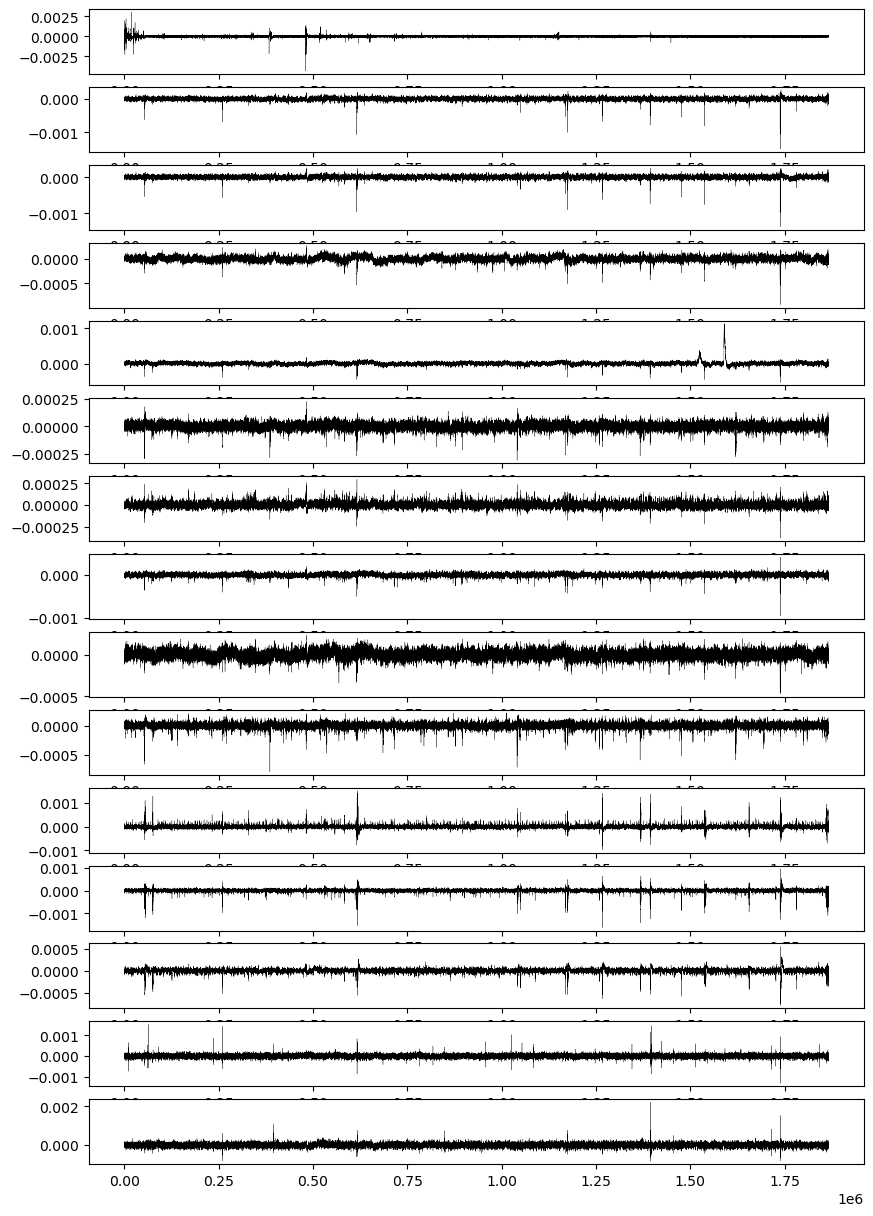

In [32]:
# Clean up the MNE data 

data = MS007_data.pick_channels([*sEEG_mapping_dict])._data
# data = data[picks]

# Find bad channels
kurt_chans = _find_outliers(kurtosis(data, axis=1))
var_chans = _find_outliers(np.var(data, axis=1))
std_chans = _find_outliers(np.std(data, axis=1))
kurt_chans = np.array([*sEEG_mapping_dict])[kurt_chans]
var_chans = np.array([*sEEG_mapping_dict])[var_chans]
std_chans = np.array([*sEEG_mapping_dict])[std_chans]

MS007_data.info['bads'] = np.unique(kurt_chans.tolist() + var_chans.tolist() + std_chans.tolist()).tolist()
# eeg_indices = mne.pick_types(epochs.info, seeg=True, exclude='bads')
# reduced_info = mne.pick_info(epochs.info, eeg_indices)

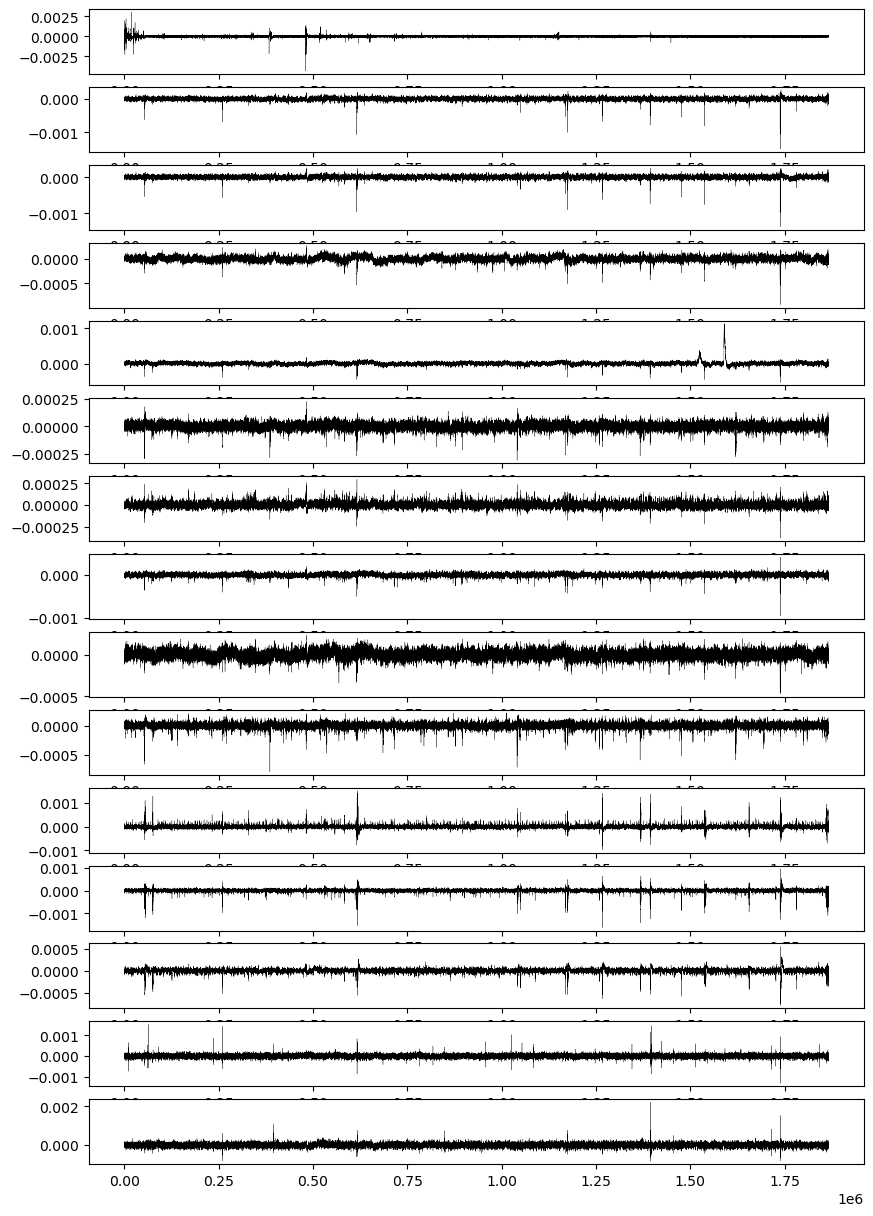

In [34]:
# Plot the supposedly bad channels: 

f, ax = plt.subplots(len(MS007_data.info['bads']), 1, figsize=(10, len(MS007_data.info['bads'])))
for ix, chan in enumerate(mne.io.pick.pick_channels(MS007_data.ch_names, MS007_data.info['bads'])): 
    ax[ix].plot(MS007_data._data[chan, :], linewidth=0.2, color='k')

In [33]:
MS007_data.info['bads'] 

['laglt10',
 'laglt8',
 'laglt9',
 'laimm11',
 'lcmfo7',
 'lhplt1',
 'lhplt2',
 'lmcms1',
 'lmcms2',
 'lmcms9',
 'lmolf4',
 'lmolf5',
 'lmolf6',
 'racas8',
 'rpcip7']

In [35]:
del data

## Data pre-processing

In [36]:
# Identify line noise
MS007_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
MS007_data.notch_filter(freqs=(60, 120, 180, 240), picks=[*sEEG_mapping_dict])

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:   10.8s finished


<RawEDF | MS007_MemBandit.edf, 196 x 1867008 (1823.2 s), ~2.73 GB, data loaded>

Now, let's use the localization data to determine the gray vs. white matter electrodes. 
Then, let's re-reference each gray matter electrode to the closest and most low-amplitude white matter electrode. 

Make sure 'bad' electrodes are not used in the re-referencing. Same with unmatched seeg electrodes (not present in the mne data structure).

In [37]:
anode_list, cathode_list = lfp_preprocess_utils.wm_ref(MS007_data, elec_locs, 
                                                       MS007_data.info['bads'], 
                                                       unmatched_seeg=unmatched_seeg)




In [38]:
mne.set_bipolar_reference(MS007_data, 
                          anode=anode_list, 
                          cathode=cathode_list,
                          copy=False)

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=108, n_times=1867008
    Range : 0 ... 1867007 =      0.000 ...  1823.249 secs
Ready.
Added the following bipolar channels:
lacas1-lmolf1, lacas10-lacas9, lacas12-lacas11, lacas2-racas3, lacas3-racas3, lacas4-racas6, lacas5-racas5, lacas6-lacas8, lacas7-lacas8, laglt1-laglt4, laglt10-laglt6, laglt2-laglt4, laglt3-laglt4, laglt7-laglt6, laglt8-lhplt7, laglt9-lhplt8, laimm1-laglt5, laimm13-laimm12, laimm2-laglt5, laimm3-lmolf6, laimm4-lmolf6, laimm5-laimm8, laimm7-laimm8, lcmfo1-lcmfo5, lcmfo12-lcmfo11, lcmfo13-lcmfo11, lcmfo2-lcmfo5, lcmfo3-lcmfo5, lcmfo8-lcmfo9, lhplt1-laglt4, lhplt10-lhplt7, lhplt2-lhplt5, lhplt3-laglt4, lhplt4-lhplt7, lhplt9-lhplt7, lmcms3-lmcms1, lmcms4-lmcms2, lmolf2-lmolf1, lmolf3-lmolf5, lmolf4-lmolf6, lmolf8-lmolf6, lmtpt1-lcmfo4, lmtpt2-lhplt7, lmtpt3-lhplt7, lmtpt4-lhplt7, lmtpt5-lhplt6, lmtpt6-lhplt7, lmtpt7-lhplt7, lmtpt8-lhplt7, lpcip1-lpcip4, lpcip11-lpcip10, lpci

<RawEDF | MS007_MemBandit.edf, 149 x 1867008 (1823.2 s), ~2.07 GB, data loaded>

Let's start applying filters to the data (other than the notch filter for line noise). 

To do so, we are going to try to follow best practices as laid out here: https://pubmed.ncbi.nlm.nih.gov/25128257/

The easiest way to follow these practices is to use the neurodsp package

In [40]:
import neurodsp
from neurodsp.sim import sim_combined
from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts import plot_time_series

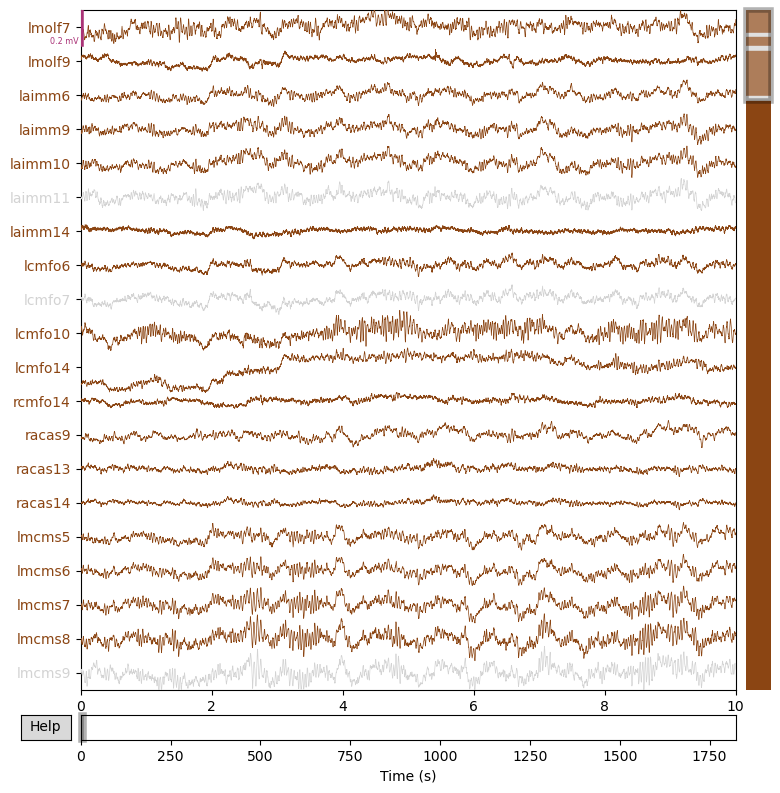

In [43]:
fig = MS007_data.plot()
fig.fake_keypress('a')

In [ ]:
# High-pass filter the data (0.1 Hz)

# Low-pass filter the data (1/2 desired sample-rate)


## Tips on resampling MNE epochs (if applicable)

Performing resampling on Raw data (before epoching) will negatively affect the temporal precision of Event arrays, by causing jitter in the event timing. This reduced temporal precision will propagate to subsequent epoching operations.


Performing resampling after epoching can introduce edge artifacts on every epoch, whereas filtering the Raw object will only introduce artifacts at the start and end of the recording (which is often far enough from the first and last epochs to have no affect on the analysis).


To avoid the reduction in temporal precision of events that comes with resampling a Raw object, and also avoid the edge artifacts that come with filtering an Epochs or Evoked object, the best practice is to:

1) low-pass filter the Raw data at or below 1/3 of the desired sample rate, then

2) decimate the data after epoching, by either passing the decim parameter to the Epochs constructor, or using the decimate() method after the Epochs have been created.

Note that this method of manually filtering and decimating is exact only when the original sampling frequency is an integer multiple of the desired new sampling frequency.

In [42]:
import re
 
# helper function to perform sort for bipolar electrodes:
def num_sort(test_string):
    return list(map(int, re.findall(r'\d+', test_string)))[0]

In [43]:
# # Plot some of the white matter electrodes so I can verify that they are low amplitude
# wm_channels = [x for x in elec_locs[elec_locs.gm=='White'].label.tolist() if x not in MS007_data.info['bads']]
# for chan in wm_channels:
#     wm_ix = MS007_data.ch_names.index(chan)
#     plt.plot(MS007_data._data[wm_ix, :4999])
#     plt.ylim([-0.0005, 0.0005])
    

In [44]:
# # Plot some of the white matter electrodes so I can verify that they are low amplitude
# gm_channels = [x for x in elec_locs[elec_locs.gm=='Gray'].label.tolist() if x not in MS007_data.info['bads']]
# for chan in gm_channels:
#     gm_ix = MS007_data.ch_names.index(chan)
#     plt.plot(MS007_data._data[gm_ix, :4999])
#     plt.ylim([-0.0005, 0.0005])
    

To perform the white matter referencing (as in https://www.science.org/doi/10.1126/sciadv.abf4198), iterate through each electrode. Find the 5 nearest white matter contacts within XX mm of the gray matter contact. Of these, select the one with the lowest amplitude signal. Set this as the reference for the signal. 

In [45]:
# # white matter reference for all gray matter electrodes

# # 1. iterate through each electrode, compute distance to all white matter electrodes 
# # 2. find 3 closest wm electrodes, compute amplitude (rms) 
# # 3. lowest amplitude electrode = wm reference 
# # 4. subtract the signals
# # 5. create new mne data structure with new montage and new channel names 
# # 6. save out 

# from scipy.spatial.distance import cdist 

# gray_matter_electrodes = [x for x in elec_locs[elec_locs.gm=='Gray'].label.tolist() if x not in MS007_data.info['bads']]
# data = []
# for gme in gray_matter_electrodes[1:2]:
#     try:
#         gm_ix = MS007_data.ch_names.index(gme)
#     except ValueError: 
#         print(f'{gme} not in the data structure?')
#         continue
#     gm_coords = elec_locs[elec_locs.label==gme][['mni_x', 'mni_y', 'mni_z']]
#     wm_coords = elec_locs[elec_locs.gm=='White'][['mni_x', 'mni_y', 'mni_z']]
#     # Compute distance to all white matter electrodes 
#     gm_wm_dist = cdist(gm_coords, wm_coords)
    
    
# #     gm_data = MS007_data._data[gm_ix, :] 
# #     data.append()
        
        
        
        

In [46]:
# bipolar reref (skip microelectrodes)
cathode_list = [] 
anode_list = [] 
names = [] 
ref_category = [] 
# make a new elec_df 
elec_df_bipolar = [] 
for bundle in elec_locs.bundle.unique():
    
    if bundle[0] == 'u':
        print('this is a microwire, pass')
        continue
        
    elec_bipol = pd.DataFrame(columns=['label', 'x', 'y' ,'z', 'mni_x', 'mni_y', 'mni_z', 'region_an', 'region_cath', 'bundle'])
        
    # Isolate the electrodes in each bundle 
    bundle_df = elec_locs[elec_locs.bundle==bundle].sort_values(by='z', ignore_index=True)
    
    # Get the electrodes if theyre in the dataset 
    all_elecs = [x for x in bundle_df.label if x in MS007_data.ch_names]
    # Sort them by number 
    all_elecs.sort(key=num_sort)
    all_elecs = [x for x in all_elecs if x not in MS007_data.info['bads']]
    # & (x.lower() not in MS007_data.info['bads']))
    # Set the cathodes and anodes 
    cath = all_elecs[1:]
    an = all_elecs[:-1]
    cathode_list.append(cath)
    anode_list.append(an)
    # Get the names 
    names.append([f'{a}-{c}' for a,c in zip(an, cath)])
    elec_bipol['label'] = [f'{a}-{c}' for a,c in zip(an, cath)]
    # Take the rolling mean of positions for the "virtual electrode"
    elec_bipol[['x', 'y' ,'z', 'mni_x', 'mni_y', 'mni_z']] = bundle_df.rolling(2).mean().dropna().reset_index(drop=True)
    elec_bipol['region_an'] = bundle_df.apply(lambda x: x.region if x.label in an else np.nan, axis=1).dropna().tolist()
    elec_bipol['region_cath'] = bundle_df.apply(lambda x: x.region if x.label in cath else np.nan, axis=1).dropna().tolist()
    elec_bipol['bundle'] = bundle
    elec_df_bipolar.append(elec_bipol)

    
cathode_list = np.hstack(cathode_list)
anode_list = np.hstack(anode_list)
names = np.hstack(names)
elec_df_bipolar = pd.concat(elec_df_bipolar)


this is a microwire, pass
this is a microwire, pass
this is a microwire, pass


In [47]:
elec_df_bipolar[elec_df_bipolar.bundle=='lhplt']

,label,x,y,z,mni_x,mni_y,mni_z,region_an,region_cath,bundle
0,lhplt3-lhplt4,-17.179276,-4.998168,-14.991739,-19.905528,-18.925393,-20.432084,Left Hippocampus,Left Hippocampus,lhplt
1,lhplt4-lhplt5,-21.973494,-5.997801,-13.992289,-25.319375,-20.022726,-19.233696,Left Hippocampus,Left Cerebral White Matter,lhplt
2,lhplt5-lhplt6,-26.967470,-6.797507,-12.992840,-31.066897,-20.989939,-18.268966,Left Cerebral White Matter,Left Cerebral White Matter,lhplt
3,lhplt6-lhplt7,-31.761688,-7.797140,-11.793501,-36.600512,-22.257991,-17.162313,Left Cerebral White Matter,Left Cerebral White Matter,lhplt
4,lhplt7-lhplt8,-36.356146,-8.796773,-10.794052,-41.953984,-23.591783,-16.288062,Left Cerebral White Matter,Left MTG middle temporal gyrus,lhplt
5,lhplt8-lhplt9,-41.350123,-9.596479,-9.994492,-47.838172,-24.745361,-15.709803,Left MTG middle temporal gyrus,Left MTG middle temporal gyrus,lhplt
6,lhplt9-lhplt10,-46.344100,-10.396186,-8.995043,-53.617560,-25.855805,-14.884746,Left MTG middle temporal gyrus,Left MTG middle temporal gyrus,lhplt


In [130]:
[x.lower() for x in anode_list]

['lacas1',
 'lacas10',
 'lacas12',
 'lacas2',
 'lacas3',
 'lacas4',
 'lacas5',
 'lacas6',
 'lacas7',
 'laglt1',
 'laglt10',
 'laglt2',
 'laglt3',
 'laglt7',
 'laglt8',
 'laglt9',
 'laimm1',
 'laimm13',
 'laimm2',
 'laimm3',
 'laimm4',
 'laimm5',
 'laimm7',
 'lcmfo1',
 'lcmfo12',
 'lcmfo13',
 'lcmfo2',
 'lcmfo3',
 'lcmfo8',
 'lhplt1',
 'lhplt10',
 'lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt9',
 'lmcms3',
 'lmcms4',
 'lmolf2',
 'lmolf3',
 'lmolf4',
 'lmolf8',
 'lmtpt1',
 'lmtpt2',
 'lmtpt3',
 'lmtpt4',
 'lmtpt5',
 'lmtpt6',
 'lmtpt7',
 'lmtpt8',
 'lpcip1',
 'lpcip11',
 'lpcip2',
 'racas1',
 'racas11',
 'racas2',
 'racas4',
 'racas7',
 'racas8',
 'raglt1',
 'raglt2',
 'raglt3',
 'raglt6',
 'raglt7',
 'raglt9',
 'raimm1',
 'raimm11',
 'raimm12',
 'raimm2',
 'raimm3',
 'raimm4',
 'raimm6',
 'raimm7',
 'raimm8',
 'rcmfo1',
 'rcmfo10',
 'rcmfo11',
 'rcmfo12',
 'rcmfo13',
 'rcmfo2',
 'rcmfo3',
 'rcmfo4',
 'rcmfo7',
 'rcmfo8',
 'rcmfo9',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt9',
 'rmcms2',
 'rmcm

In [36]:
MS007_data.ch_names

['lmolf7',
 'lmolf9',
 'laimm6',
 'laimm9',
 'laimm10',
 'laimm11',
 'laimm14',
 'lcmfo6',
 'lcmfo7',
 'lcmfo10',
 'lcmfo14',
 'rcmfo14',
 'racas9',
 'racas13',
 'racas14',
 'lmcms5',
 'lmcms6',
 'lmcms7',
 'lmcms8',
 'lmcms9',
 'lmcms10',
 'rmcms8',
 'rmcms10',
 'lpcip3',
 'lpcip5',
 'lpcip6',
 'lpcip7',
 'lpcip8',
 'lpcip9',
 'lpcip12',
 'rpcip3',
 'rpcip6',
 'rpcip8',
 'rpcip10',
 'rpcip12',
 'raglt10',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rmtpt3',
 'rmtpt5',
 'lacas1-lmolf1',
 'lacas10-lacas9',
 'lacas12-lacas11',
 'lacas2-racas3',
 'lacas3-racas3',
 'lacas4-racas6',
 'lacas5-racas5',
 'lacas6-lacas8',
 'lacas7-lacas8',
 'laglt1-laglt4',
 'laglt10-laglt6',
 'laglt2-laglt4',
 'laglt3-laglt4',
 'laglt7-laglt6',
 'laglt8-lhplt7',
 'laglt9-lhplt8',
 'laimm1-laglt5',
 'laimm13-laimm12',
 'laimm2-laglt5',
 'laimm3-lmolf6',
 'laimm4-lmolf6',
 'laimm5-laimm8',
 'laimm7-laimm8',
 'lcmfo1-lcmfo5',
 'lcmfo12-lcmfo11',
 'lcmfo13-lcmfo11',
 'lcmfo2-lcmfo5',
 'lcmfo3-lcmfo5',
 'lcmfo8-lcmfo9',
 'l

In [50]:
MS007_data.save(f'{save_dir}/bipolar_ieeg.fif', overwrite=True)
elec_df_bipolar.to_csv(f'{save_dir}/bipolar_electrode_data.csv', index=False)

Overwriting existing file.
Writing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/bipolar_ieeg.fif
Closing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/bipolar_ieeg.fif
[done]


From here, I can just load the data and the bipolar elec_info df and analyze data from there.

In [3]:
MS007_data = mne.io.read_raw_fif(f'{save_dir}/bipolar_ieeg.fif')
elec_df_bipolar = pd.read_csv(f'{save_dir}/bipolar_electrode_data.csv')
MB1_ts = pd.read_csv(f'{save_dir}/MB1_ts.csv')
MEM2_ts = pd.read_csv(f'{save_dir}/MEM2_ts.csv')
rm_df = pd.read_csv(f'{save_dir}/rm_df.csv')
mb_df = pd.read_csv(f'{save_dir}/mb_df.csv')
sync_data = pd.read_csv(f'{save_dir}/sync_data.csv')


Opening raw data file /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/bipolar_ieeg.fif...
    Range : 0 ... 1867007 =      0.000 ...  1823.249 secs
Ready.


In [4]:
slope = sync_data.slope.values[0]
offset =  sync_data.offset.values[0]

## Make MNE Epochs

In [5]:
# Set everything in iEEG time and then add it to the MNE via annotations:

# Example: choice times in the two-arm bandit and memory tasks

gambling_choice_times = [(x*slope + offset) for x in MB1_ts['choice']]
memory_choice_times = [(x*slope + offset) for x in MEM2_ts['choice']]

gambling_cross_start =  [(x*slope + offset) for x in MB1_ts['ITI_start']]
memory_cross_start =  [(x*slope + offset) for x in MEM2_ts['ITI_start']]
gambling_cross_stop =  [(x*slope + offset) for x in MB1_ts['ITI_stop']]
memory_cross_stop =  [(x*slope + offset) for x in MEM2_ts['ITI_stop']]

gambling_feedback_times =  [(x*slope + offset) for x in MB1_ts['feedback_start']]

memory_face_times = [(x*slope + offset) for x in MEM2_ts['face_start']]

memory_slider_times = [(x*slope + offset) for x in MEM2_ts['slider_start']]

behav_events = gambling_choice_times + memory_choice_times + gambling_feedback_times + memory_face_times + memory_slider_times

behav_duration = np.zeros_like(gambling_choice_times).tolist() + np.zeros_like(memory_choice_times).tolist() + np.ones_like(gambling_feedback_times).tolist() + np.zeros_like(memory_face_times).tolist() + np.zeros_like(memory_slider_times).tolist()

behav_description = ['gambling_choice']*len(gambling_choice_times) + ['memory_choice']*len(memory_choice_times) + ['gambling_feedback']*len(gambling_feedback_times) + ['memory_cue']*len(memory_face_times) + ['memory_slider_start']*len(memory_slider_times)

# If this were a particular epoch I would need a duration 
my_annot = mne.Annotations(onset=behav_events,
                          duration=behav_duration,
                          description=behav_description)

MS007_data.set_annotations(my_annot)

events_from_annot, event_dict = mne.events_from_annotations(MS007_data)

buf = 1.0 # second

epochs = mne.Epochs(MS007_data, events_from_annot, event_id=event_dict, baseline=None, tmin=-buf, tmax=buf, reject=None, preload=True)

# Make baseline epochs for 2-arm bandit: 
my_annot = mne.Annotations(onset=gambling_cross_start,
                          duration=0.5,
                          description=['gambling_cross']*len(gambling_cross_start))

MS007_data.set_annotations(my_annot)
events_from_annot, event_dict = mne.events_from_annotations(MS007_data)

mb_baseline_epochs = mne.Epochs(MS007_data, events_from_annot, event_id=event_dict, baseline=None, tmin=-buf, tmax=0.5+buf, reject=None, preload=True)

# Make baseline epochs for recognition memory: 
my_annot = mne.Annotations(onset=memory_cross_start,
                          duration=0.5,
                          description=['memory_cross']*len(memory_cross_start))

MS007_data.set_annotations(my_annot)
events_from_annot, event_dict = mne.events_from_annotations(MS007_data)

rm_baseline_epochs = mne.Epochs(MS007_data, events_from_annot, event_id=event_dict, baseline=None, tmin=-buf, tmax=0.5+buf, reject=None, preload=True)


Used Annotations descriptions: ['gambling_choice', 'gambling_feedback', 'memory_choice', 'memory_cue', 'memory_slider_start']
Not setting metadata
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Loading data for 480 events and 2049 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['gambling_cross']
Not setting metadata
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Loading data for 60 events and 2561 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['memory_cross']
Not setting metadata
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Loading data for 120 events and 2561 original time points ...
0 bad epochs dropped


In [21]:
epochs.get_pic

['lmoif4',
 'lmoif5',
 'lmoif6',
 'lalmm11',
 'lcmfo7',
 'racas8',
 'lmcms1',
 'lmcms2',
 'lmcms9',
 'rpcip7',
 'laglt8',
 'laglt9',
 'laglt10',
 'lhplt1',
 'lhplt2',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt3-raglt4',
 'raglt4-raglt5',
 'raglt5-raglt6',
 'raglt6-raglt7',
 'raglt7-raglt8',
 'raglt8-raglt9',
 'raglt9-raglt10',
 'lmtpt1-lmtpt2',
 'lmtpt2-lmtpt3',
 'lmtpt3-lmtpt4',
 'lmtpt4-lmtpt5',
 'lmtpt5-lmtpt6',
 'lmtpt6-lmtpt7',
 'lmtpt7-lmtpt8',
 'laglt1-laglt2',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt4-laglt5',
 'laglt5-laglt6',
 'laglt6-laglt7',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt5-lhplt6',
 'lhplt6-lhplt7',
 'lhplt7-lhplt8',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'rhplt1-rhplt2',
 'rhplt2-rhplt3',
 'rhplt3-rhplt4',
 'rhplt4-rhplt5',
 'rhplt5-rhplt6',
 'rhplt6-rhplt7',
 'rhplt7-rhplt8',
 'lcmfo1-lcmfo2',
 'lcmfo2-lcmfo3',
 'lcmfo3-lcmfo4',
 'lcmfo4-lcmfo5',
 'lcmfo5-lcmfo6',
 'lcmfo6-lcmfo8',
 'lcmfo8-lcmfo9',
 'lcmfo9-lcmfo10',
 'lcmfo10-lcmfo11',
 'lcmfo11-lcmfo12'

In [6]:
epochs.resample(sfreq=MS007_data.info['sfreq']/2)
mb_baseline_epochs.resample(sfreq=MS007_data.info['sfreq']/2)
rm_baseline_epochs.resample(sfreq=MS007_data.info['sfreq']/2)

Number of events,120
Events,memory_cross: 120
Time range,-1.000 – 1.498 sec
Baseline,off


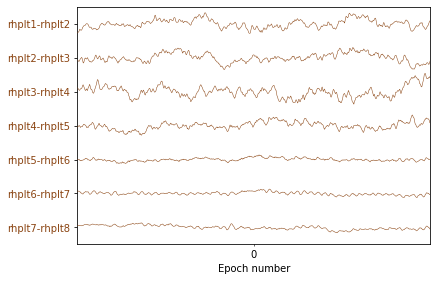

In [7]:
fig = epochs['gambling_choice'].plot(picks = [x for x in epochs.ch_names if x.startswith('rhp') ], 
                               n_epochs=1,
                              show_scrollbars=False)

## Analyze LFP with respect to gambling choice and memory choice

In [8]:
elec_df_bipolar.region_an.unique()

array(['Right Amygdala', 'Right Ent entorhinal area',
       'Right Cerebral White Matter', 'Right PP planum polare',
       'Right STG superior temporal gyrus',
       'Right MTG middle temporal gyrus',
       'Left ITG inferior temporal gyrus', 'Left FuG fusiform gyrus',
       'Left Cerebellum Exterior', 'Left Ent entorhinal area',
       'Left Amygdala', 'Left Cerebral White Matter', 'Left Hippocampus',
       'Left MTG middle temporal gyrus', 'Right Hippocampus',
       'Left Thalamus Proper', 'Left PIns posterior insula',
       'Left CO central operculum', 'Left PoG postcentral gyrus',
       'Left PCgG posterior cingulate gyrus', 'Left AnG angular gyrus',
       'Right MSFG superior frontal gyrus medial segment',
       'Right ACgG anterior cingulate gyrus',
       'Right SFG superior frontal gyrus', 'Right AIns anterior insula',
       'Right FO frontal operculum',
       'Right OpIFG opercular part of the inferior frontal gyrus',
       'Right MFG middle frontal gyrus',
     

In [9]:
# Make a region dict that can look for keywords to provide a nicer label for each electrode 
region_dict = {'EC': ['entorhinal'], 
               'INS': ['insula'],
               'THA': ['Thalamus'],
               'HPC': ['Hippocampus'],
               'PHG': ['parahippocampal'], 
               'AMY': ['Amygdala'],
               'ACC': ['anterior cingulate'],
               'PCC': ['posterior cingulate'],
               'Frontal': ['GRe', 'MOrG', 'AOrG', 'LOrG', 'frontal']} 

elec_df_bipolar['salman_region_an'] = np.nan
for key, item in region_dict.items(): 
    elec_df_bipolar['salman_region_an'][elec_df_bipolar.apply(lambda x: any(x.region_an.find(term) > -1 for term in item), axis=1)
] = key
    
elec_df_bipolar['salman_region_cath'] = np.nan
for key, item in region_dict.items(): 
    elec_df_bipolar['salman_region_cath'][elec_df_bipolar.apply(lambda x: any(x.region_cath.find(term) > -1 for term in item), axis=1)
] = key

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
def baseline_epochs(data, baseline): 
    
    """
    baseline epochs of interest against a chosen baseline 
    """
    
    # Create an array of the mean and standard deviation of the power values across the session
    # 1. Compute the mean for every electrode, at every frequency 
    m = np.mean(np.mean(baseline, axis=3) ,axis=0)
    # 2. Expand the array
    m = np.expand_dims(np.expand_dims(m, axis=0),axis=3)
    # 3. Copy the data to every event and time-point
    m = np.repeat(np.repeat(m, data.shape[0],axis=0), 
                  data.shape[-1],axis=3)

    sd = np.std(np.mean(baseline, axis=3),axis=0)
    sd = np.expand_dims(np.expand_dims(sd, axis=0),axis=3)
    sd = np.repeat(np.repeat(sd, data.shape[0], axis=0), 
                   data.shape[-1],axis=3)

    zpower_data = (data-m)/sd
    
    return zpower_data

# Decision-making data

Here, I make a conscious choice to baseline the data to the 750 ms RIGHT before receiving feedback. 

In [9]:
# Let's plot the power for the decision-making epoch 
# Re compute power without averaging over events
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]

freqs = np.logspace(*np.log10([4, 128]), num=30)
n_cycles = 5  
buf_ms = 1000
sr = epochs.info['sfreq']
buf_ix = int(buf_ms*(sr/1000))

# picks = [x for x in good_chans if ((elec_df_bipolar[elec_df_bipolar.label==x].salman_region_an=='Frontal').bool() | (elec_df_bipolar[elec_df_bipolar.label==x].salman_region_cath=='Frontal').bool())]

gambling_choice_pow = mne.time_frequency.tfr_morlet(epochs['gambling_choice'],
                                             freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, n_jobs=1, average=False)


# IF I were to baseline against the fixation cross.... 

# gambling_baseline_pow = mne.time_frequency.tfr_morlet(mb_baseline_epochs['gambling_cross'],
#                                               freqs=freqs, n_cycles=n_cycles, use_fft=True,
#                         return_itc=False, n_jobs=1,average=False)


Not setting metadata


In [10]:
zpower_data = baseline_epochs(gambling_choice_pow._data[:, :, :, buf_ix:-buf_ix//3], 
                              gambling_choice_pow._data[:, :, :, buf_ix//3:buf_ix])

In [11]:
gambling_choice_pow._data[:, :, :, buf_ix:-buf_ix//3].shape

(60, 163, 30, 341)

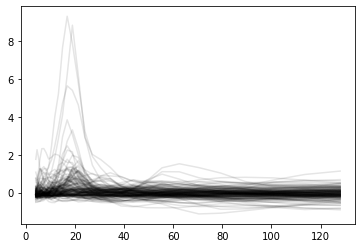

In [92]:
psds = np.nanmean(np.nanmean(zpower_data, axis=0), axis=-1)
for ix, chan in enumerate(psds): 
        plt.plot(freqs, chan, color='k', alpha=0.1)

# Plot all electrodes

In [102]:
elec_df_bipolar

,label,x,y,z,mni_x,mni_y,mni_z,region_an,region_cath,bundle,salman_region_an,salman_region_cath
0,raglt1-raglt2,19.776151,10.796032,-16.191078,21.279005,-1.191912,-23.342490,Right Amygdala,Right Amygdala,raglt,AMY,AMY
1,raglt2-raglt3,24.770128,10.995959,-14.991739,27.096920,-0.997580,-22.354668,Right Amygdala,Right Ent entorhinal area,raglt,AMY,EC
2,raglt3-raglt4,29.564345,11.395812,-13.992289,32.684941,-0.669872,-21.705171,Right Ent entorhinal area,Right Cerebral White Matter,raglt,EC,NaN
3,raglt4-raglt5,34.358563,11.795665,-12.992840,38.159728,-0.330706,-21.084067,Right Cerebral White Matter,Right PP planum polare,raglt,NaN,NaN
4,raglt5-raglt6,39.152781,12.195518,-11.993391,43.572411,-0.035840,-20.505966,Right PP planum polare,Right STG superior temporal gyrus,raglt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
158,rmolf4-rmolf5,18.977115,44.783552,-6.996144,21.724970,37.752718,-13.372303,Right MOrG medial orbital gyrus,Right MOrG medial orbital gyrus,rmolf,Frontal,Frontal
159,rmolf5-rmolf6,22.772537,44.783552,-3.997796,26.475605,37.801856,-10.434350,Right MOrG medial orbital gyrus,Right AOrG anterior orbital gyrus,rmolf,Frontal,Frontal
160,rmolf6-rmolf7,26.767719,44.783552,-0.799558,31.325255,37.985773,-7.195379,Right AOrG anterior orbital gyrus,Right Cerebral White Matter,rmolf,Frontal,NaN
161,rmolf7-rmolf8,30.563141,44.783552,2.398680,35.878263,38.258240,-3.857482,Right Cerebral White Matter,Right Cerebral White Matter,rmolf,NaN,NaN


First, let's plot the rewarded vs. unrewarded draws for each channel 

In [24]:
reward_mask = mb_df.reward.astype(bool).values

rewarded_chan = np.nanmean(zpower_data[reward_mask, :, :, :], axis=0)
unrewarded_chan  = np.nanmean(zpower_data[~reward_mask, :, :, :], axis=0)

save_file = f'{save_dir}/plots/all_channels_gamble_reward.pdf'
with PdfPages(save_file) as pdf:
    for ix, (r_chan, ur_chan) in enumerate(zip(rewarded_chan, unrewarded_chan)):

        elec_df_entry = elec_df_bipolar.iloc[ix]

        # Plot results
        f, (unrew_plot, rew_plot) = plt.subplots(1, 2, figsize=[8, 3], dpi=300)
        im = unrew_plot.imshow(ur_chan, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-1, vmax=1)
        rew_plot.imshow(r_chan, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-1, vmax=1)


        unrew_plot.invert_yaxis()
        rew_plot.invert_yaxis()

        # unrew_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
        unrew_plot.set_yticks(np.arange(0, len(freqs), 4))
        unrew_plot.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
        unrew_plot.set_xticks(np.linspace(0, rewarded_chan.shape[-1], 5))
        unrew_plot.set_xticklabels(np.linspace(0, 750, 5))
        unrew_plot.set_xlabel('Time (ms)', fontsize=12)
        unrew_plot.set_ylabel('Frequency (Hz)', fontsize=12)
        unrew_plot.set_title('Unrewarded Gamble', color='red')

        # rew_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
        rew_plot.set_yticks(np.arange(0, len(freqs), 4))
        rew_plot.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
        rew_plot.set_xticks(np.linspace(0, rewarded_chan.shape[-1], 5))
        rew_plot.set_xticklabels(np.linspace(0, 750, 5))
        rew_plot.set_title('Rewarded Gamble', color ='green')

        f.colorbar(im, ax=rew_plot)
        f.colorbar(im, ax=unrew_plot)

        f.suptitle(f'{elec_df_entry.label}, regions={elec_df_entry.region_an}-{elec_df_entry.region_cath}')

        f.tight_layout()
        pdf.savefig()
        plt.close(f)

Next, let's plot the each draw as a function of RPE (neg, none, pos) 

In [26]:
pos_RPE_mask = ((mb_df['RPE_discrete']=='pos') | (mb_df['RPE_discrete']=='med_pos')).values
zero_RPE_mask = (mb_df['RPE_discrete']=='zero').values
neg_RPE_mask = ((mb_df['RPE_discrete']=='neg') | (mb_df['RPE_discrete']=='med_neg')).values


pos_RPE_chan = np.nanmean(zpower_data[pos_RPE_mask, :, :, :], axis=0)
neg_RPE_chan = np.nanmean(zpower_data[zero_RPE_mask, :, :, :], axis=0)
zero_RPE_chan = np.nanmean(zpower_data[neg_RPE_mask, :, :, :], axis=0)

save_file = f'{save_dir}/plots/all_channels_gamble_RPE.pdf'
with PdfPages(save_file) as pdf:
    for ix, (n_chan, z_chan, p_chan) in enumerate(zip(neg_RPE_chan, 
                                                      zero_RPE_chan, 
                                                      pos_RPE_chan)):

        elec_df_entry = elec_df_bipolar.iloc[ix]

        # Plot results
        f, (neg_plot, zero_plot, pos_plot) = plt.subplots(1, 3, figsize=[12, 3], dpi=300)
        im = neg_plot.imshow(n_chan, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-1, vmax=1)
        zero_plot.imshow(z_chan, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-1, vmax=1)
        pos_plot.imshow(p_chan, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-1, vmax=1)


        neg_plot.invert_yaxis()
        zero_plot.invert_yaxis()
        pos_plot.invert_yaxis()

        # neg_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
        neg_plot.set_yticks(np.arange(0, len(freqs), 4))
        neg_plot.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
        neg_plot.set_xticks(np.linspace(0, pos_RPE_chan.shape[-1], 5))
        neg_plot.set_xticklabels(np.linspace(0, 750, 5))
        neg_plot.set_xlabel('Time (ms)', fontsize=12)
        neg_plot.set_ylabel('Frequency (Hz)', fontsize=12)
        neg_plot.set_title('Neg RPE', color='red')

        # zero_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
        zero_plot.set_yticks(np.arange(0, len(freqs), 4))
        zero_plot.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
        zero_plot.set_xticks(np.linspace(0, pos_RPE_chan.shape[-1], 5))
        zero_plot.set_xticklabels(np.linspace(0, 750, 5))
        zero_plot.set_title('No RPE', color='black')

        # pos_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
        pos_plot.set_yticks(np.arange(0, len(freqs), 4))
        pos_plot.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
        pos_plot.set_xticks(np.linspace(0, pos_RPE_chan.shape[-1], 5))
        pos_plot.set_xticklabels(np.linspace(0, 750, 5))
        pos_plot.set_title('Pos RPE', color='green')
        
        f.colorbar(im, ax=neg_plot)
        f.colorbar(im, ax=zero_plot)
        f.colorbar(im, ax=pos_plot)

        f.suptitle(f'{elec_df_entry.label}, regions={elec_df_entry.region_an}-{elec_df_entry.region_cath}')

        f.tight_layout()
        pdf.savefig()
        plt.close(f)

# Memory data

Here, I ought to baseline memory epoch to the fixation cross, as memory might be occurring both before and after button-press.... 

In [9]:
# Let's plot the power for the decision-making epoch 
# Re compute power without averaging over events
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]

freqs = np.logspace(*np.log10([4, 128]), num=30)
n_cycles = 5  
buf_ms = 1000
sr = epochs.info['sfreq']
buf_ix = int(buf_ms*(sr/1000))

picks = good_chans
# picks = [x for x in good_chans if ((elec_df_bipolar[elec_df_bipolar.label==x].salman_region_an=='Frontal').bool() | (elec_df_bipolar[elec_df_bipolar.label==x].salman_region_cath=='Frontal').bool())]

memory_choice_pow = mne.time_frequency.tfr_morlet(epochs['memory_choice'], picks=picks, 
                                             freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, n_jobs=1, average=False)


# IF I were to baseline against the fixation cross.... 

memory_baseline_pow = mne.time_frequency.tfr_morlet(rm_baseline_epochs['memory_cross'], picks=picks,
                                              freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, n_jobs=1,average=False)


Not setting metadata
Not setting metadata


In [18]:
zpower_data = baseline_epochs(memory_choice_pow._data[:, :, :, buf_ix//4:-buf_ix//4], 
                              memory_baseline_pow._data[:, :, :, buf_ix:-buf_ix])

In [23]:
zpower_data.shape

(120, 163, 30, 768)

In [20]:
hit_bool = rm_df.hit.astype(bool).values
miss_bool = rm_df.miss.astype(bool).values
pos_RPE_mask = ((rm_df['RPE_discrete']=='pos') | (rm_df['RPE_discrete']=='med_pos')).values
zero_RPE_mask = (rm_df['RPE_discrete']=='zero').values
neg_RPE_mask = ((rm_df['RPE_discrete']=='neg') | (rm_df['RPE_discrete']=='med_neg')).values

In [25]:
for ix, mem_mask in enumerate([hit_bool, miss_bool]):
    if ix==0:
        save_file = f'{save_dir}/plots/all_channels_memory_HIT_RPE.pdf'
    else:
        save_file = f'{save_dir}/plots/all_channels_memory_MISS_RPE.pdf'
        
    neg_RPE_chan = np.nanmean(zpower_data[((mem_mask) & (neg_RPE_mask)), :, :, :], axis=0)
    zero_RPE_chan = np.nanmean(zpower_data[((mem_mask) & (zero_RPE_mask)), :, :, :], axis=0) 
    pos_RPE_chan = np.nanmean(zpower_data[((mem_mask) & (pos_RPE_mask)), :, :, :], axis=0)
    
    with PdfPages(save_file) as pdf:
        for ix, (n_chan, z_chan, p_chan) in enumerate(zip(neg_RPE_chan, 
                                                          zero_RPE_chan, 
                                                          pos_RPE_chan)):

            elec_df_entry = elec_df_bipolar.iloc[ix]

            # Plot results
            f, (neg_plot, zero_plot, pos_plot) = plt.subplots(1, 3, figsize=[12, 3], dpi=300)
            im = neg_plot.imshow(n_chan, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-1, vmax=1)
            zero_plot.imshow(z_chan, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-1, vmax=1)
            pos_plot.imshow(p_chan, aspect='auto', interpolation='bicubic', cmap='RdBu_r', vmin=-1, vmax=1)


            neg_plot.invert_yaxis()
            zero_plot.invert_yaxis()
            pos_plot.invert_yaxis()

            neg_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
            neg_plot.set_yticks(np.arange(0, len(freqs), 4))
            neg_plot.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
            neg_plot.set_xticks(np.linspace(0, pos_RPE_chan.shape[-1], 5))
            neg_plot.set_xticklabels(np.linspace(-750, 750, 5))
            neg_plot.set_xlabel('Time (ms)', fontsize=12)
            neg_plot.set_ylabel('Frequency (Hz)', fontsize=12)
            neg_plot.set_title('Neg RPE', color='red')

            zero_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
            zero_plot.set_yticks(np.arange(0, len(freqs), 4))
            zero_plot.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
            zero_plot.set_xticks(np.linspace(0, pos_RPE_chan.shape[-1], 5))
            zero_plot.set_xticklabels(np.linspace(-750, 750, 5))
            zero_plot.set_title('No RPE', color='black')

            pos_plot.vlines(3*buf_ix//4, 0, len(freqs)-1, 'k')
            pos_plot.set_yticks(np.arange(0, len(freqs), 4))
            pos_plot.set_yticklabels(np.round(freqs[np.arange(0, len(freqs), 4)]), fontsize=10)
            pos_plot.set_xticks(np.linspace(0, pos_RPE_chan.shape[-1], 5))
            pos_plot.set_xticklabels(np.linspace(-750, 750, 5))
            pos_plot.set_title('Pos RPE', color='green')

            f.colorbar(im, ax=neg_plot)
            f.colorbar(im, ax=zero_plot)
            f.colorbar(im, ax=pos_plot)

            f.suptitle(f'{elec_df_entry.label}, regions={elec_df_entry.region_an}-{elec_df_entry.region_cath}')

            f.tight_layout()
            pdf.savefig()
            plt.close(f)

# Ripple detection

Here, I am going to do ripple detection following the example of Foster's lab: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8288441/

i) time domain detection for identifying putative ripple events

ii) frequency domain assessment for accepting/rejecting ripple events

iii) electrode wise ripple count thresholding for inclusion/exclusion.

In [11]:
def rolling_rms(x, N):
    """
    Note this starts N samples after the start.... so prepend samples
    """
    x = np.insert(x[0:N], 0, x)
    xc = np.cumsum(abs(x)**2);
    rms_data = np.sqrt((xc[N:] - xc[:-N]) / N)
    return rms_data

In [49]:
def ripple_detection(signal, lb, ub, min_len, max_len):
    """
    Based on https://stackoverflow.com/questions/71746585/find-runs-and-lengths-of-consecutive-values-in-an-array
    """
    
    arr = (signal>lb) & (signal<ub) # Get True where this condn is passed
    
    res = np.ones_like(arr)
    np.bitwise_xor(arr[:-1], arr[1:], out=res[1:])  # set equal, consecutive elements to 0
    idxs = np.flatnonzero(res)                      # get indices of non zero elements
    values = arr[idxs]
    counts = np.diff(idxs, append=len(arr))         # difference between consecutive indices are the length

    cond = (counts > min_len) & (counts < max_len)
    values[cond], counts[cond], idxs[cond]

    ripple_length = counts[cond][values[cond]] # use the bools to find runs of True 
    ripple_ix = idxs[cond][values[cond]]
    
    return (ripple_ix, ripple_length)